In [ ]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from prettytable import PrettyTable
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import soundfile as sf
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns

Mounted at /content/drive


In [ ]:
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/train_val.csv')
bird_df.head(1)

,primary_label,duration_secs,filename_npy,type,rating,class_weight_file,class_weight_duration,class_weight_combined,orig_index,country,continent,data
0,thrnig1,15.0,thrnig1/XC139346.npy,song,good,0.937876,0.419757,0.627439,13869,RU,EU,train


In [ ]:
bird_train_df = bird_df[bird_df['data'] == 'train']
bird_train_df.shape

(1348, 12)

In [ ]:
species_counts = bird_train_df['primary_label'].value_counts()
print(species_counts)

comsan     154
woosan     143
eaywag1    138
cohmar1    136
combuz1    135
barswa     133
eubeat1    133
hoopoe     128
wlwwar     126
thrnig1    122
Name: primary_label, dtype: int64


In [ ]:
#lets create a separate validation set
bird_val_df =  bird_df[bird_df['data'] == 'val']
bird_val_df.shape

(445, 12)

In [ ]:
#let's filter the train and the validation data sets to contain only top 5 species for testing
def filter_top_species(bird_train_df, species_list):
    filtered_train_df = bird_train_df[bird_train_df['primary_label'].isin(species_list)]
    filtered_val_df = bird_val_df[bird_val_df['primary_label'].isin(species_list)]
    return filtered_train_df, filtered_val_df

In [ ]:
#lets call the train and the validation filtered sets
species_list = ['comsan', 'woosan', 'eaywag1']
filtered_train_df, filtered_val_df = filter_top_species(bird_train_df, species_list)
print(filtered_train_df.shape)
print(filtered_val_df.shape)

(435, 12)
(142, 12)


In [ ]:
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

In [ ]:
# Function to load the loudest 5-second audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [ ]:
#chunk the audio into 5 sec frame
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = 16000,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [ ]:
# Count the number of audio files that are exactly 15 seconds
num_15_sec = len(filtered_train_df[filtered_train_df['duration_secs'] == 15])

# Count the number of audio files that are less than 15 seconds
num_less_than_15_sec = len(filtered_train_df[filtered_train_df['duration_secs'] < 15])

print("Number of audio files that are exactly 15 seconds:", num_15_sec)
print("Number of audio files that are less than 15 seconds:", num_less_than_15_sec)

Number of audio files that are exactly 15 seconds: 249
Number of audio files that are less than 15 seconds: 186


In [ ]:
import numpy as np
import librosa
from sklearn.preprocessing import MinMaxScaler


def generate_gaussian_noise(length, mean=0, std=1):
    gaussian_noise = np.random.normal(mean, std, length)
    return gaussian_noise

def extract_mfcc_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=40):
    scaler = MinMaxScaler(feature_range=(0, 1))
    mfcc_frames = []
    target_label = []

    for frame in framed_audio:
        frame = np.array(frame)

        #Extract mfcc from the main audio frame without augmentation
        mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)
        scaled_mfcc = scaler.fit_transform(mfcc.reshape(-1, 1)).flatten()

        # Replicate frame
        replicated_frame_1 = frame.copy()
        replicated_frame_2 = frame.copy()
        replicated_frame_3 = frame.copy()

        #flip the third frame
        flipped_frame = np.flip(replicated_frame_3)


        # Add Gaussian noise to first frame alone
        gaussian_noise_1 = generate_gaussian_noise(len(replicated_frame_1))

        replicated_frame_1 += gaussian_noise_1

        pitch_shift_factor_1 = 2  # Adjust the value as needed

        # Perform pitch shift on second frame
        pitch_shifted_frame_1 = librosa.effects.pitch_shift(y=replicated_frame_2, sr=sample_rate, n_steps=pitch_shift_factor_1)

        # Extract MFCC features from the modified frames
        mfcc_2 = librosa.feature.mfcc(y=replicated_frame_1, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_3 = librosa.feature.mfcc(y=pitch_shifted_frame_1, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_4 = librosa.feature.mfcc(y=flipped_frame, sr=sample_rate, n_mfcc=n_mfcc)


        # Scale MFCC
        scaled_mfcc_2 = scaler.fit_transform(mfcc_2.reshape(-1, 1)).flatten()
        scaled_mfcc_3 = scaler.fit_transform(mfcc_3.reshape(-1, 1)).flatten()
        scaled_mfcc_4 = scaler.fit_transform(mfcc_4.reshape(-1, 1)).flatten()

        # Append MFCC features and target label
        mfcc_frames.append(scaled_mfcc)
        mfcc_frames.append(scaled_mfcc_2)
        mfcc_frames.append(scaled_mfcc_3)
        mfcc_frames.append(scaled_mfcc_4)
        target_label.append(class_label)
        target_label.append(class_label)
        target_label.append(class_label)
        target_label.append(class_label)

    return mfcc_frames, target_label

In [ ]:
#loop through the data and extract segments for all the audios
def extract_final_features_from_dataframe(df):
    mfccs = []
    target_labels = []
    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        audio = load_audio(file_name)  # Load the audio using the load_audio function
        framed_audio = frame_audio(audio)  # Frame the audio into 5-second segments
        mfcc_frames,target_label = extract_mfcc_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=40)  # Extract MFCC features for each frame
        mfccs.extend(mfcc_frames)
        target_labels.extend(target_label)
    return mfccs, target_labels

In [ ]:
#extract the embeddings from the model
embeddings, labels = extract_final_features_from_dataframe(filtered_train_df)

In [ ]:
#verify the shapes
x_train = np.array(embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(11680, 6280)
(11680,)


In [ ]:
#lets extract the embeddings
val_embeddings, val_labels = extract_final_features_from_dataframe(filtered_val_df)

In [ ]:
#verify the val data shapes
x_val = np.array(val_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(3660, 6280)
(3660,)


In [ ]:
#get the encoded y_train and y_val
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val
#lets call the function
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)

In [ ]:
#lets verify y shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(11680, 3)
(3660, 3)


In [ ]:
#lets perform PCA and select only the essential features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(x_train, x_val, desired_variance=1000):
    # Fit PCA on x_train
    pca = PCA(n_components=1000)
    x_train_pca = pca.fit_transform(x_train)

    # Apply the same PCA transformation on x_val
    x_val_pca = pca.transform(x_val)

    return x_train_pca, x_val_pca

#lets call the pca function
x_train_pca, x_val_pca = apply_pca(x_train, x_val)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def train_sequential_model(x_train, y_train, x_val, y_val, learning_rate=0.01, batch_size=32, n_classes=3, epochs=100):

    # Create the sequential model
    model = Sequential()
    model.add(Dense(512, input_dim=x_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

    return history

In [ ]:
history = train_sequential_model(x_train_pca, y_train_encoded, x_val_pca, y_val_encoded, learning_rate=0.01, batch_size=32, n_classes=3, epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               512512    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

In [ ]:
# Evaluating The Model training accuracy
model = history.model
score = model.evaluate(x_train_pca, y_train_encoded, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 77.21%


In [ ]:
# Evaluating The Model validation accuracy
model = history.model
score = model.evaluate(x_val_pca, y_val_encoded, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 51.53%


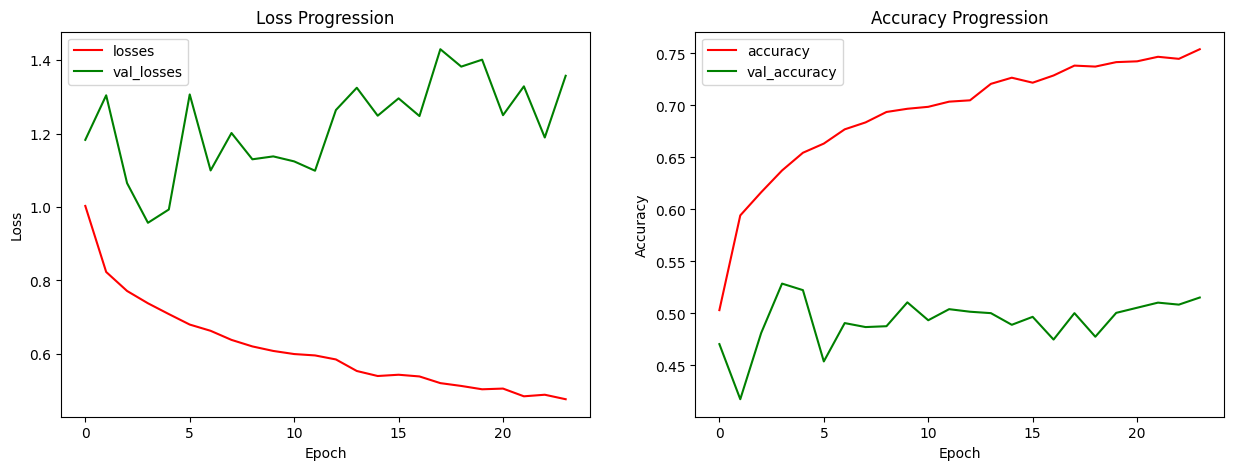

In [ ]:
num_epochs = len(history.history['loss'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(num_epochs), history.history['loss'], color='red', label='losses')
axes[0].plot(range(num_epochs), history.history['val_loss'], color='green', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(range(num_epochs), history.history['accuracy'], color='red', label='accuracy')
axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='green', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()

plt.show()

In [ ]:
test_pred = np.argmax(model.predict(x_val_pca), axis=-1)
print(test_pred)

115/115 [==============================] - 1s 7ms/step
[0 1 1 ... 1 0 0]


              precision    recall  f1-score   support

           0      0.585     0.412     0.483      1132
           1      0.391     0.686     0.498      1052
           2      0.687     0.473     0.560      1476

    accuracy                          0.515      3660
   macro avg      0.554     0.524     0.514      3660
weighted avg      0.570     0.515     0.519      3660



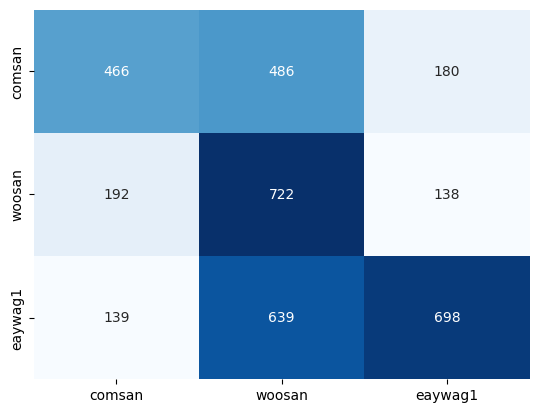

In [ ]:
class_label = ['comsan', 'woosan', 'eaywag1']
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics


# # Convert y_test to 1D format
y_test_1d = np.argmax(y_val_encoded, axis=1)

# # Calculate confusion matrix
cm_1 = confusion_matrix(y_test_1d, test_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_1d, test_pred)

# Plot confusion matrix
ax = sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_test_1d, test_pred, digits=3))

Convolution Neural Network

In [ ]:
sample_size = x_train_pca.shape[0] # number of samples in train set
time_steps  = x_train_pca.shape[1] # number of features in train set
input_dimension = 1

#Reshape the input data to match the model's input shape
x_reshaped = x_train_pca.reshape(sample_size,time_steps,input_dimension)
x_reshaped.shape

(11680, 1000, 1)

In [ ]:
sample_size = x_val_pca.shape[0] # number of samples in train set
time_steps  = x_val_pca.shape[1] # number of features in train set
input_dimension = 1

#Reshape the input data to match the model's input shape
x_reshaped_val = x_val_pca.reshape(sample_size,time_steps,input_dimension)
x_reshaped_val.shape

(3660, 1000, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

def train_sequential_model(x_train, y_train, x_val, y_val, learning_rate=0.01, batch_size=32, n_classes=5, epochs=150):

    # Create the sequential model
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

    return history

In [ ]:
history = train_sequential_model(x_reshaped, y_train_encoded, x_reshaped_val, y_val_encoded, learning_rate=0.01, batch_size=32, n_classes=3, epochs=150)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 998, 32)           128       
                                                                 
 batch_normalization_6 (Batc  (None, 998, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 499, 32)          0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 499, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 497, 64)           6208      
                                                                 
 batch_normalization_7 (Batc  (None, 497, 64)         

In [ ]:
# Evaluating The Model training accuracy
model = history.model
score = model.evaluate(x_reshaped, y_train_encoded, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 88.70%


In [ ]:
# Evaluating The Model validation accuracy
model = history.model
score = model.evaluate(x_reshaped_val, y_val_encoded, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 54.15%


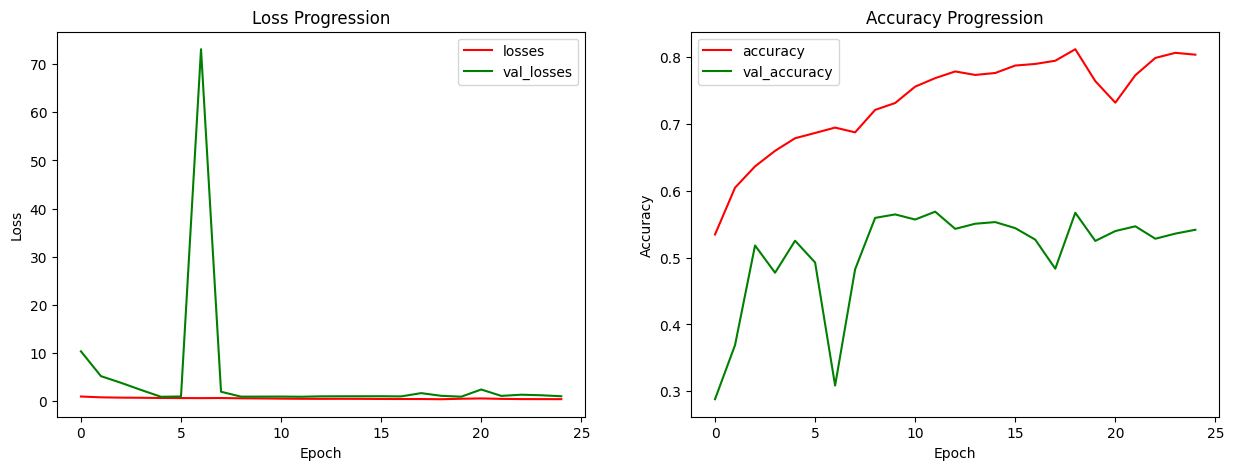

In [ ]:
num_epochs = len(history.history['loss'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(num_epochs), history.history['loss'], color='red', label='losses')
axes[0].plot(range(num_epochs), history.history['val_loss'], color='green', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(range(num_epochs), history.history['accuracy'], color='red', label='accuracy')
axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='green', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()

plt.show()

In [ ]:
test_pred = np.argmax(model.predict(x_reshaped_val), axis=-1)
print(test_pred)

115/115 [==============================] - 2s 19ms/step
[1 0 1 ... 0 1 0]


              precision    recall  f1-score   support

           0      0.530     0.467     0.497      1132
           1      0.555     0.479     0.514      1052
           2      0.541     0.643     0.588      1476

    accuracy                          0.542      3660
   macro avg      0.542     0.530     0.533      3660
weighted avg      0.542     0.542     0.538      3660



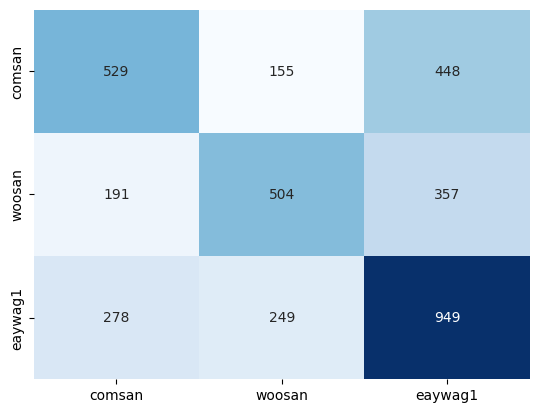

In [ ]:
class_label = ['comsan', 'woosan', 'eaywag1']
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics


# # Convert y_test to 1D format
y_test_1d = np.argmax(y_val_encoded, axis=1)

# # Calculate confusion matrix
cm_1 = confusion_matrix(y_test_1d, test_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_1d, test_pred)

# Plot confusion matrix
ax = sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_test_1d, test_pred, digits=3))